In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True, precision=4)
from plot_helpers import plotMatches, plotCoordinateFrame

In [2]:
images = ['data/chair/0000001-000000000000.jpg', 'data/chair/0000050-000001642284.jpg']

K = np.array([[525. ,   0. , 319.5,   0. ],
       [  0. , 525. , 239.5,   0. ],
       [  0. ,   0. ,   1. ,   0. ]])

In [3]:
images = ['data/statue/PXL_20221118_141420115.jpg', 'data/statue/PXL_20221118_141422652.jpg']

K = np.array([[3271.7198,    0.,     1539.6885, 0],
             [   0.,     3279.7956, 2027.496, 0],
             [   0.,        0.,        1.,0    ]])
scale_percent = 25 # percent of original size
K[:2] *= scale_percent/100

# load images
im1 = cv2.imread(images[0])
im2 = cv2.imread(images[1])

width = int(im1.shape[1] * scale_percent / 100)
height = int(im2.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
im1 = cv2.resize(im1, dim, interpolation = cv2.INTER_AREA)
im2 = cv2.resize(im2, dim, interpolation = cv2.INTER_AREA)

In [8]:
%matplotlib inline

# find features
feat = cv2.SIFT_create()
kp1, des1 = feat.detectAndCompute(im1,None)
kp2, des2 = feat.detectAndCompute(im2,None)
    
# match features
bf = cv2.BFMatcher()
good_match = []
knn_matches = bf.match(des1, des2)
knn_matches = sorted(knn_matches, key = lambda x:x.distance)

idx = 5000

# img3 = cv2.drawMatches(im1, kp1, im2, kp2, knn_matches[:idx], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# plt.figure(figsize=(15,10))
# plt.imshow(img3), plt.show()

kp1 = np.array([k.pt for k in kp1])
kp2 = np.array([k.pt for k in kp2])
print(kp1.shape)


# perform ratio test
matches = np.array([[m.queryIdx, m.trainIdx] for m in knn_matches])[:idx]
# for m,n in knn_matches:
#     if m.distance < 0.5*n.distance:
#         matches.append([m.queryIdx, m.trainIdx])
# matches = np.array(matches)
kp1_match = kp1[matches[:,0]]
kp2_match = kp2[matches[:,1]]
print(kp1_match.shape)

# find essential matrix
E, inlier = cv2.findEssentialMat(kp1_match, kp2_match, K[:3,:3], method=cv2.RANSAC, threshold=1.5, prob=0.99)
inlier = inlier.flatten().astype('bool')
kp1_match = kp1_match[inlier]
kp2_match = kp2_match[inlier]
print(kp1_match.shape)

# recover pose
points, R, t, inlier = cv2.recoverPose(E, kp1_match, kp2_match, K[:3,:3])
inlier = inlier.flatten() != 0
kp1_match = kp1_match[inlier]
kp2_match = kp2_match[inlier]
print(points, kp1_match.shape)
# plotMatches(im1, im2, kp1_match, kp2_match, figsize=(15,10))

T = np.eye(4)
T[:3,:3] = R
T[:3,3] = t.flatten()
print(T)

# triangulate
Ps = cv2.triangulatePoints(K, K@T, kp1_match.T, kp2_match.T).T

Ps /= Ps[:,3:]
Ps
np.min(Ps[:,2]), np.max(Ps[:,2])

(5511, 2)
(5000, 2)
(1760, 2)
1731 (1731, 2)
[[ 0.9891 -0.0128  0.1465 -0.9997]
 [ 0.0107  0.9998  0.0149  0.0203]
 [-0.1466 -0.0132  0.9891 -0.0168]
 [ 0.      0.      0.      1.    ]]


(1.3134491538225141, 39.255472124090474)

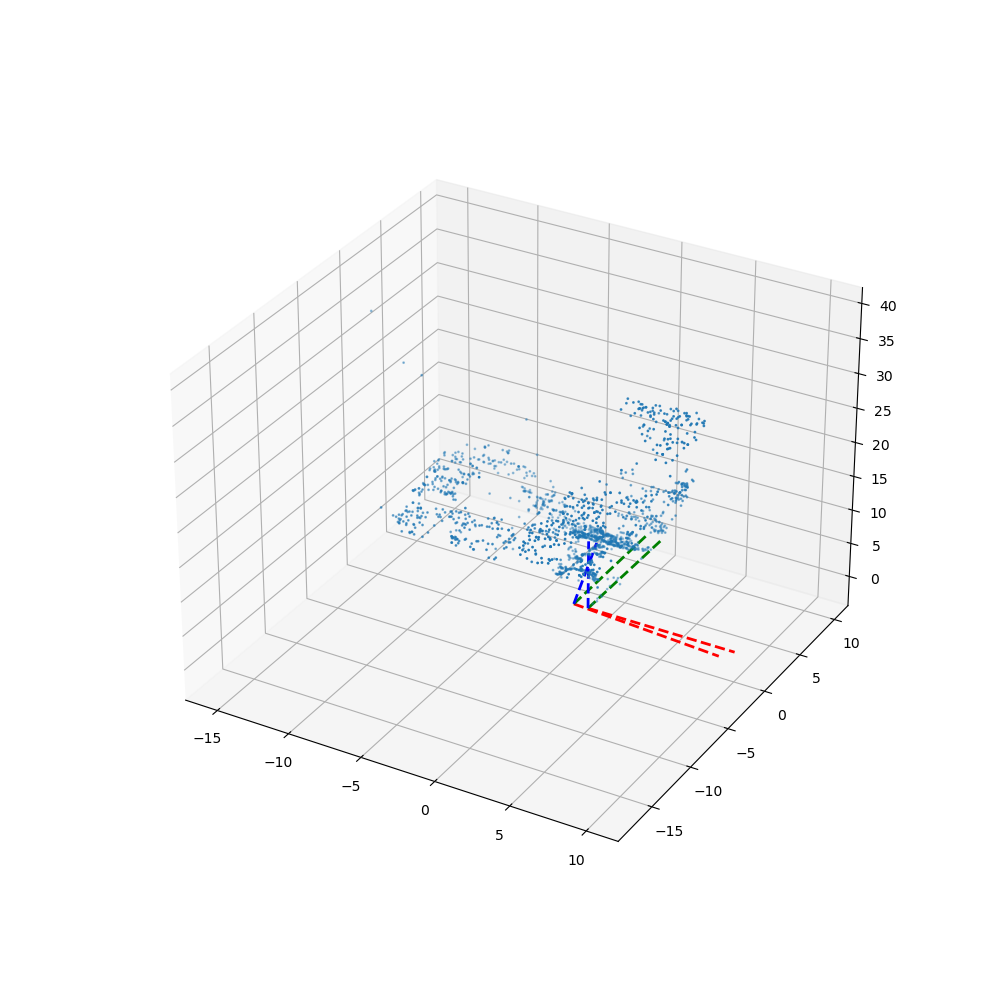

In [5]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Ps[:,0], Ps[:,1], Ps[:,2], s=1)
plotCoordinateFrame(T, ax=ax, k="--", size=10)
plotCoordinateFrame(np.eye(4), ax=ax, k="--", size=10)